## This example is a modified version of:
#### https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/

### Modified to split the data preparation and model training steps into two notebooks
### This notebook covers data preparation for training on neural networks
### One hot encode all categorical features and Standardize numeric features


# Customer Churn Prediction


## Background

_This notebook has been adapted from an [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)_

Losing customers is costly for any business.  Identifying unhappy customers early on gives you a chance to offer them incentives to stay.  This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use an example of churn that is familiar to all of us–leaving a mobile phone operator.  Seems like I can always find fault with my provider du jour! And if my provider knows that I’m thinking of leaving, it can offer timely incentives–I can always use a phone upgrade or perhaps have a new feature activated–and I might just stick around. Incentives are often much more cost effective than losing and reacquiring a customer.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
import re
from IPython.display import display
from time import strftime, gmtime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, KBinsDiscretizer, LabelEncoder
# Column Transformer
from sklearn.compose import ColumnTransformer

---
## Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.  Let's download and read that dataset in now:

### Download Data From: http://dataminingconsultant.com/DKD2e_data_sets.zip

By modern standards, it’s a relatively small dataset, with only 3,333 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `Account Length`: the number of days that this account has been active
- `Area Code`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `Int’l Plan`: whether the customer has an international calling plan: yes/no
- `VMail Plan`: whether the customer has a voice mail feature: yes/no
- `VMail Message`: presumably the average number of voice mail messages per month
- `Day Mins`: the total number of calling minutes used during the day
- `Day Calls`: the total number of calls placed during the day
- `Day Charge`: the billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: the billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls
- `CustServ Calls`: the number of calls placed to Customer Service
- `Churn?`: whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the target attribute–the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let's begin exploring the data:

In [2]:
# Download Data From: http://dataminingconsultant.com/DKD2e_data_sets.zip
# And Unzip the file DKD2e_data_sets.zip
# !unzip -o DKD2e_data_sets.zip

In [3]:
# !unzip -o DKD2e_data_sets.zip

In [4]:
# Output columns
columns = ["Churn?", "State", "Account Length", "Area Code", "Int'l Plan",
           "VMail Plan", "VMail Message", "Day Mins", "Day Calls", 
           "Eve Mins", "Eve Calls", 
           "Night Mins", "Night Calls",
           "Intl Mins", "Intl Calls",
           "CustServ Calls"]

In [5]:
df = pd.read_csv('churn.txt')
pd.set_option('display.max_columns', 30)

In [6]:
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [7]:
df.dtypes

State              object
Account Length      int64
Area Code           int64
Phone              object
Int'l Plan         object
VMail Plan         object
VMail Message       int64
Day Mins          float64
Day Calls           int64
Day Charge        float64
Eve Mins          float64
Eve Calls           int64
Eve Charge        float64
Night Mins        float64
Night Calls         int64
Night Charge      float64
Intl Mins         float64
Intl Calls          int64
Intl Charge       float64
CustServ Calls      int64
Churn?             object
dtype: object

In [8]:
df.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [9]:
# Frequency tables for each categorical feature
for column in df.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=df[column], columns='% observations', normalize='columns'))

col_0,% observations
State,
AK,0.015602
AL,0.024002
AR,0.016502
AZ,0.019202
CA,0.010201
CO,0.019802
CT,0.022202
DC,0.016202
DE,0.018302


col_0,% observations
Phone,
327-1058,0.0003
327-1319,0.0003
327-3053,0.0003
327-3587,0.0003
327-3850,0.0003
...,...
422-7728,0.0003
422-8268,0.0003
422-8333,0.0003


col_0,% observations
Int'l Plan,
no,0.90309
yes,0.09691


col_0,% observations
VMail Plan,
no,0.723372
yes,0.276628


col_0,% observations
Churn?,
False.,0.855086
True.,0.144914


We can see immediately that:
- `State` appears to be quite evenly distributed
- `Phone` takes on too many unique values to be of any practical use.  It's possible parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it.
- Only 14% of customers churned, so there is some class imabalance, but nothing extreme.
- Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity.  `VMail Message` being a notable exception (and `Area Code` showing up as a feature we should convert to non-numeric).

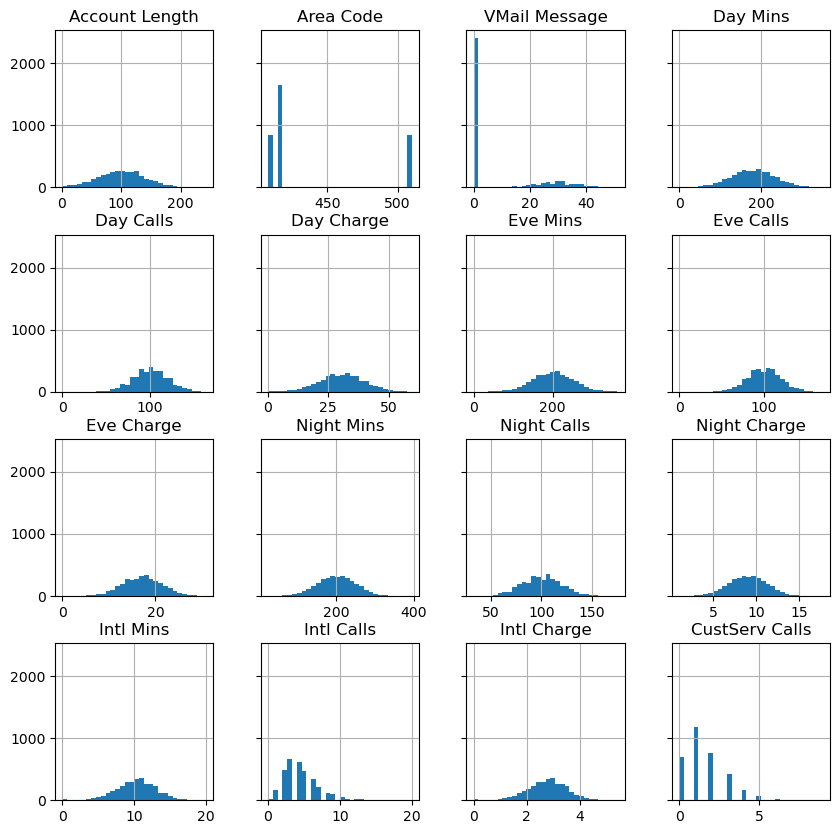

In [10]:
# Histograms for each numeric features
hist = df.hist(bins=30, sharey=True, figsize=(10, 10))

In [11]:
df.drop(columns=['Phone'], inplace=True)
df['Area Code'] = df['Area Code'].astype(object)

Next let's look at the relationship between each of the features and our target variable.

In [12]:
for column in df.select_dtypes(include=['object']).columns:
    if column != 'Churn?':
        display(pd.crosstab(index=df[column], columns=df['Churn?'], normalize='columns'))

Churn?,False.,True.
State,,
AK,0.017193,0.006211
AL,0.025263,0.016563
AR,0.015439,0.022774
AZ,0.021053,0.008282
CA,0.008772,0.018634
CO,0.020000,0.018634
CT,0.021754,0.024845
DC,0.017193,0.010352
DE,0.018246,0.018634


Churn?,False.,True.
Area Code,,
408,0.251228,0.252588
415,0.497895,0.488613
510,0.250877,0.258799


Churn?,False.,True.
Int'l Plan,,
no,0.934737,0.716356
yes,0.065263,0.283644


Churn?,False.,True.
VMail Plan,,
no,0.704561,0.834369
yes,0.295439,0.165631


Account Length


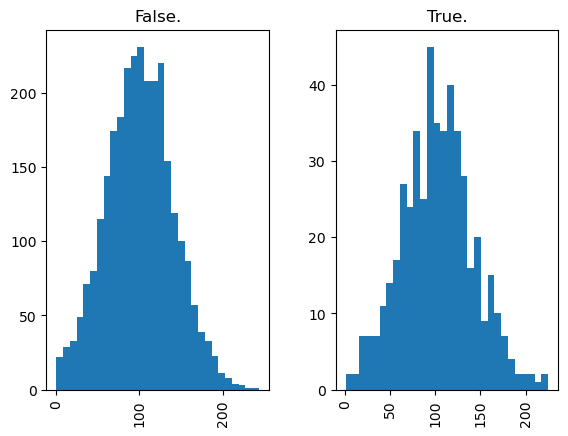

VMail Message


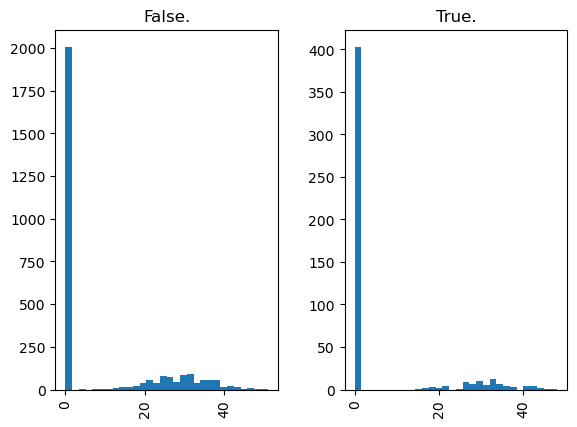

Day Mins


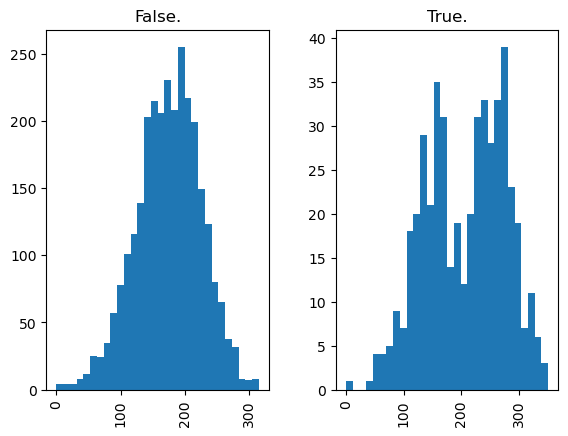

Day Calls


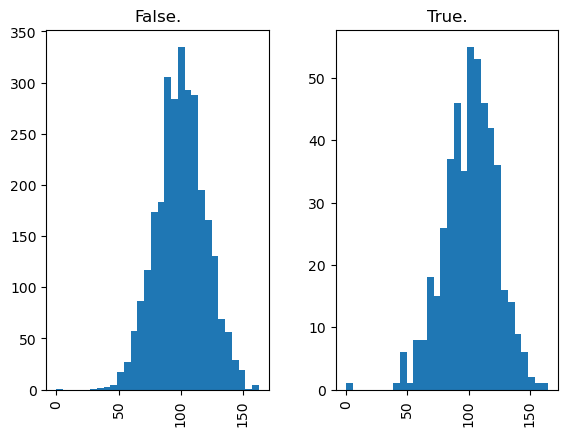

Day Charge


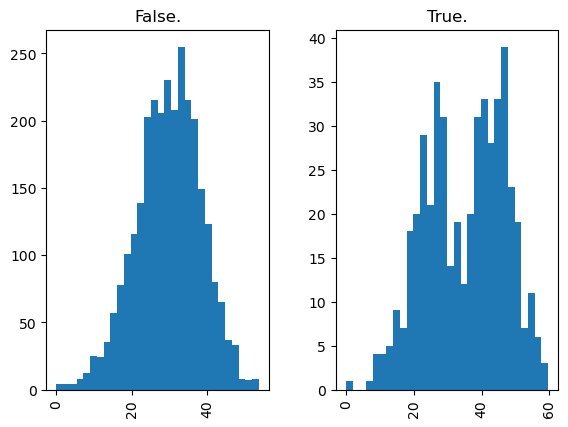

Eve Mins


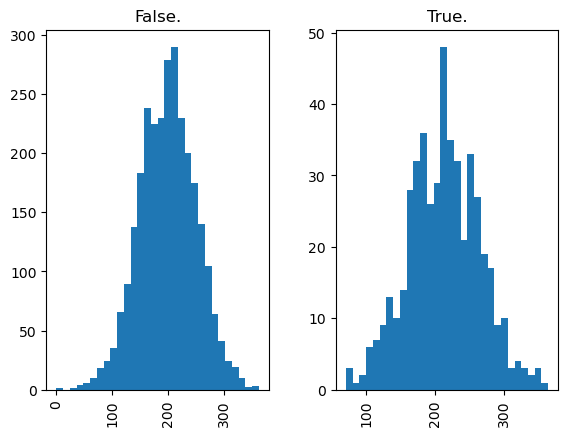

Eve Calls


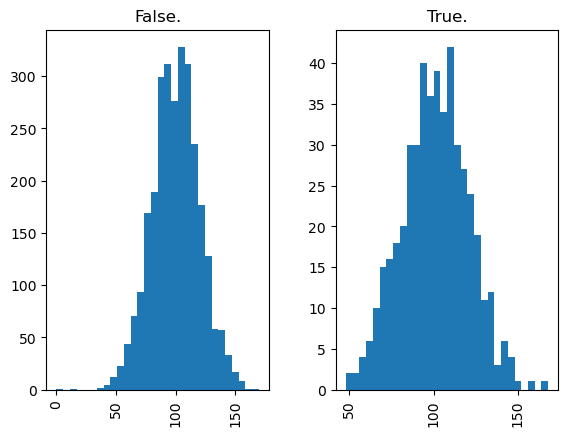

Eve Charge


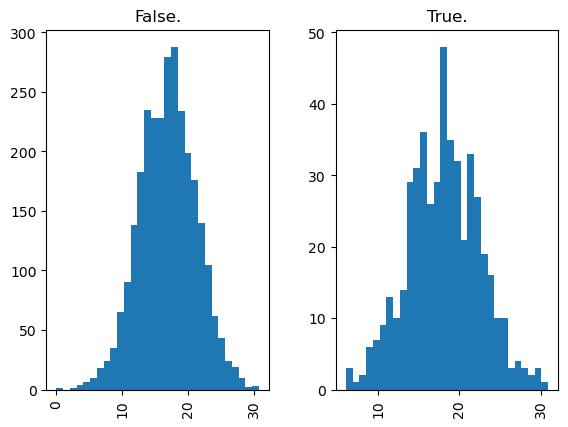

Night Mins


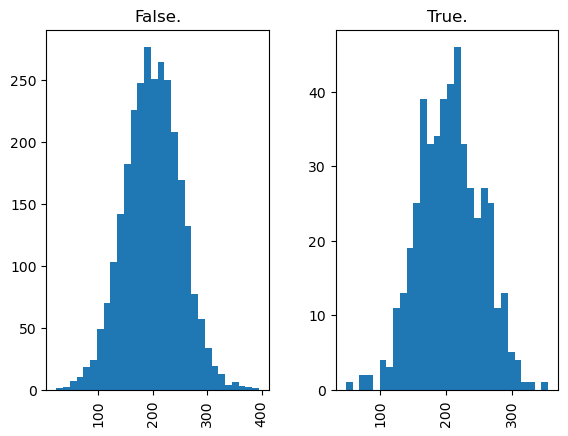

Night Calls


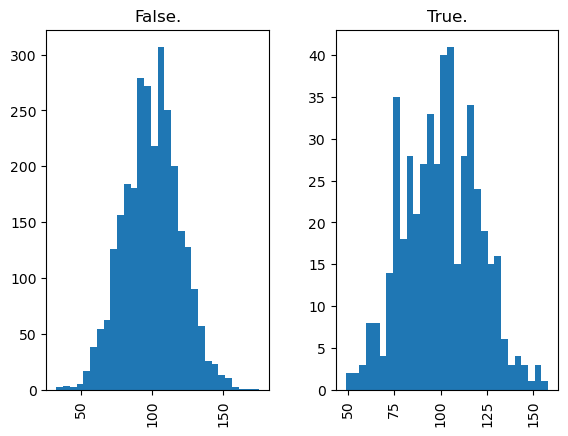

Night Charge


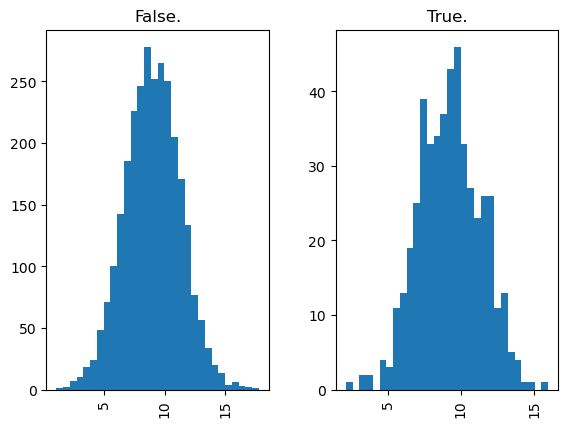

Intl Mins


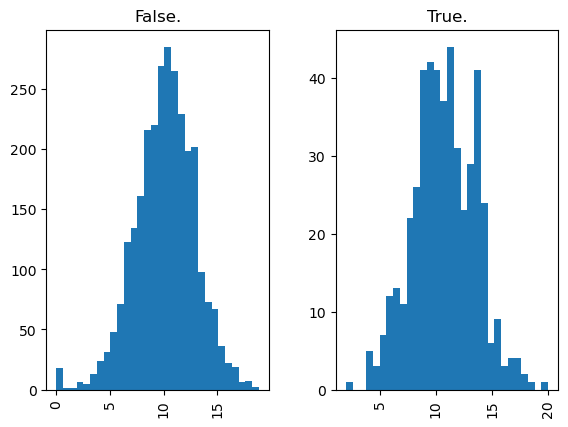

Intl Calls


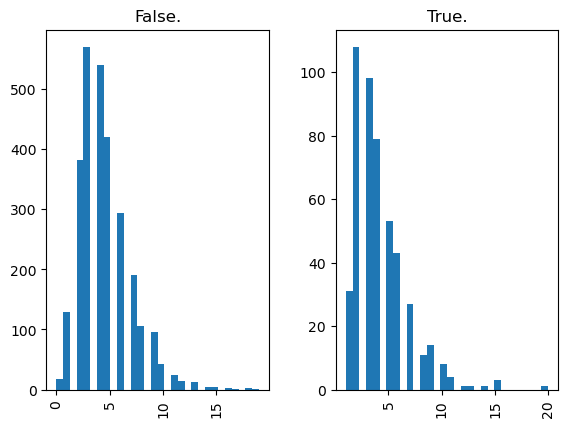

Intl Charge


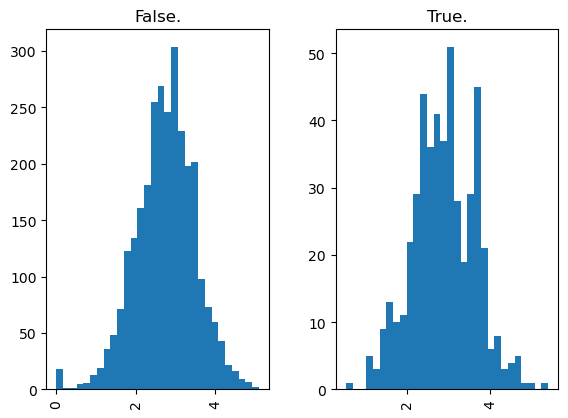

CustServ Calls


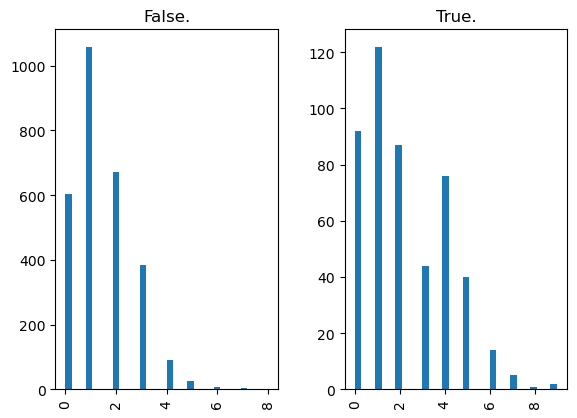

In [13]:
for column in df.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = df[[column, 'Churn?']].hist(by='Churn?', bins=30)
    plt.show()

In [16]:
display(df.corr(numeric_only=True))

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796
VMail Message,-0.004628,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263
Day Mins,0.006216,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423
Day Calls,0.038470,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942
Day Charge,0.006214,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427
Eve Mins,-0.006757,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985
Eve Calls,0.019260,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423
Eve Charge,-0.006745,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987
Night Mins,-0.008955,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288
Night Calls,-0.013176,0.007123,0.022972,-0.019557,0.022972,0.007586,0.007710,0.007596,0.011204,1.000000,0.011188,-0.013605,0.000305,-0.013630,-0.012802


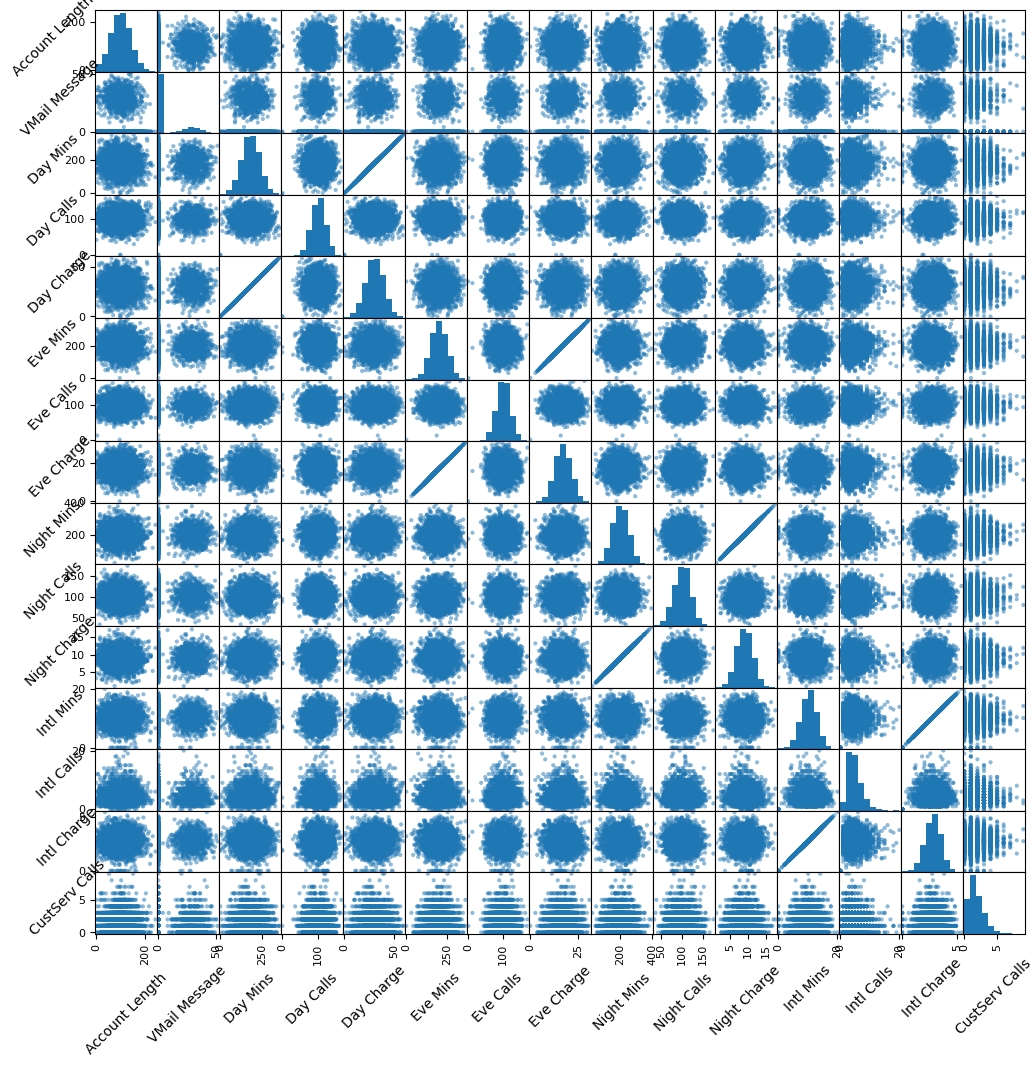

In [17]:
# https://stackoverflow.com/questions/43217174/how-can-the-sizes-and-rotations-of-text-of-a-pandas-scatter-matrix-be-set
scatter_matrix = pd.plotting.scatter_matrix(df, figsize=(12, 12))

for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 10, rotation = 45)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 10, rotation = 45)        
    
plt.show()    

We see several features that essentially have 100% correlation with one another.  Including these feature pairs in some machine learning algorithms can create catastrophic problems, while in others it will only introduce minor redundancy and bias.  Let's remove one feature from each of the highly correlated pairs: Day Charge from the pair with Day Mins, Night Charge from the pair with Night Mins, Intl Charge from the pair with Intl Mins:

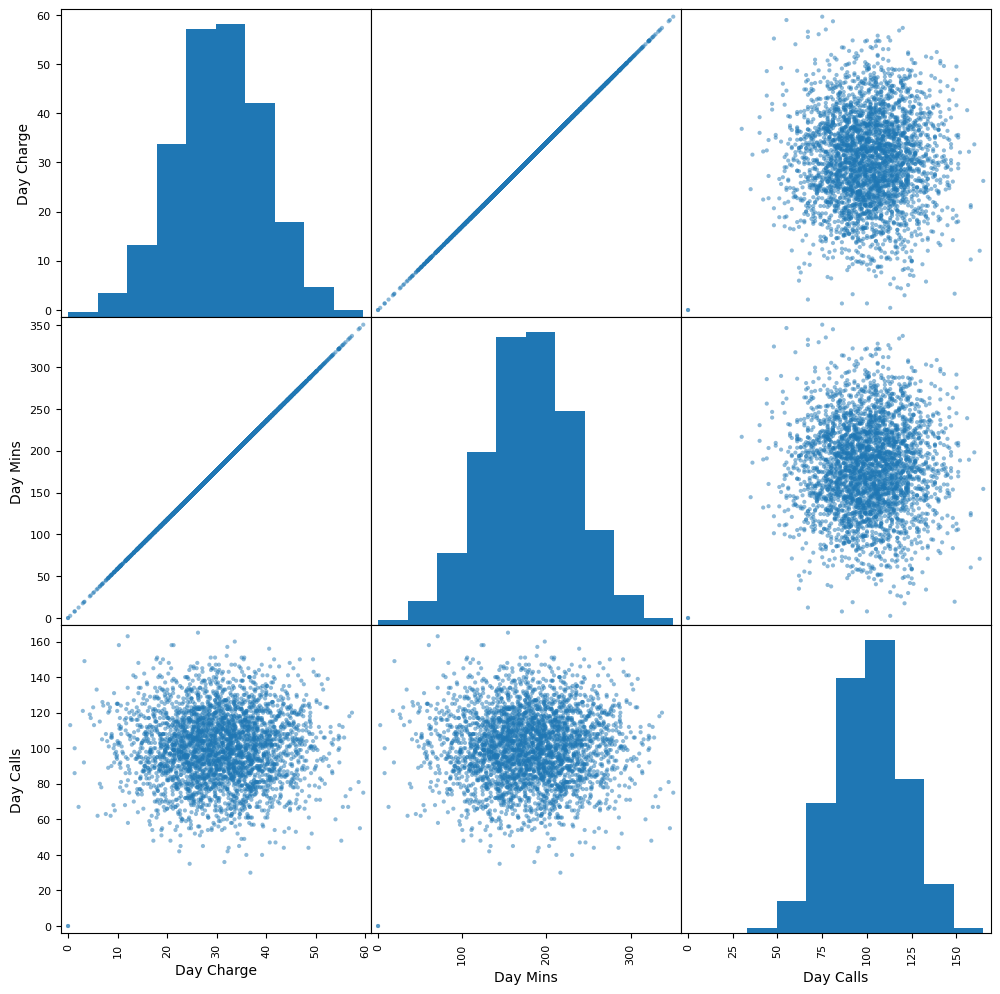

In [18]:
pd.plotting.scatter_matrix(df[['Day Charge','Day Mins','Day Calls']], figsize=(12, 12))
plt.show()

In [19]:
# Drop columns that are highly correlated with other columns
df.drop(columns=['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], inplace=True)

Now that we've cleaned up our dataset, let's determine which algorithm to use.  As mentioned above, there appear to be some variables where both high and low (but not intermediate) values are predictive of churn.  In order to accommodate this in an algorithm like linear regression, we'd need to generate polynomial (or bucketed) terms.  Instead, let's attempt to model this problem using gradient boosted trees.  Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint.  XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should:
- Have the predictor variable in the first column
- Not have a header row

But first, let's convert our categorical features into numeric features.

In [20]:
#encode_features =  ["Churn?", "State", "Int'l Plan", "VMail Plan"]
# df['Churn?'].unique()

state_list = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
churn_list = ['False.', 'True.']
plans = ['no', 'yes']

# Encode Class Labels to integers
state_le = LabelEncoder()
state_le.fit(state_list)

churn_le = LabelEncoder()
churn_le.fit(churn_list)

plans_le = LabelEncoder()
plans_le.fit(plans)

LabelEncoder()

In [21]:
df.head()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn?
0,KS,128,415,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False.
1,OH,107,415,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False.
2,NJ,137,415,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False.
3,OH,84,408,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False.
4,OK,75,415,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False.


In [22]:
# Encode specific columns
df['State'] = state_le.transform(df['State'])
df['Churn?'] = churn_le.transform(df['Churn?'])
df["Int'l Plan"] = plans_le.transform(df["Int'l Plan"])
df["VMail Plan"] = plans_le.transform(df["VMail Plan"])

In [23]:
df.head()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn?
0,16,128,415,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,35,107,415,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,31,137,415,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,35,84,408,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,36,75,415,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


In [24]:
df.tail()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn?
3328,3,192,415,0,1,36,156.2,77,215.5,126,279.1,83,9.9,6,2,0
3329,49,68,415,0,0,0,231.1,57,153.4,55,191.3,123,9.6,4,3,0
3330,39,28,510,0,0,0,180.8,109,288.8,58,191.9,91,14.1,6,2,0
3331,6,184,510,1,0,0,213.8,105,159.6,84,139.2,137,5.0,10,2,0
3332,42,74,415,0,1,25,234.4,113,265.9,82,241.4,77,13.7,4,0,0


In [25]:
df.shape

(3333, 16)

## Additional Data Transformation
### One Hot Encoding of categorical features and Standardization of numeric features

### Both these transformation are required for training on linear models and on neural network

In [26]:
# Customer churn is a binary label - no need to one hot encode
# However, for multi-class classification, label needs to be one hot encoded for neural network training.

# All other categorical features need to be 
categorical_features =['State',"Int'l Plan","VMail Plan",'Area Code']

numeric_features = ['Account Length','VMail Message',
                    'Day Mins','Day Calls','Eve Mins','Eve Calls','Night Mins','Night Calls',
                   'Intl Mins','Intl Calls','CustServ Calls']

In [27]:
categorical_features + numeric_features

['State',
 "Int'l Plan",
 'VMail Plan',
 'Area Code',
 'Account Length',
 'VMail Message',
 'Day Mins',
 'Day Calls',
 'Eve Mins',
 'Eve Calls',
 'Night Mins',
 'Night Calls',
 'Intl Mins',
 'Intl Calls',
 'CustServ Calls']

In [30]:
colTransformer = ColumnTransformer(
    [('onehot',OneHotEncoder(categories='auto',sparse=False),categorical_features),
     ('standardize',StandardScaler(),numeric_features)],
    remainder="passthrough")

In [31]:
colTransformer.fit(df[categorical_features + numeric_features])

C:\Users\ouraccount\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot', OneHotEncoder(sparse=False),
                                 ['State', "Int'l Plan", 'VMail Plan',
                                  'Area Code']),
                                ('standardize', StandardScaler(),
                                 ['Account Length', 'VMail Message', 'Day Mins',
                                  'Day Calls', 'Eve Mins', 'Eve Calls',
                                  'Night Mins', 'Night Calls', 'Intl Mins',
                                  'Intl Calls', 'CustServ Calls'])])

In [32]:
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), 
                                                  [int(0.7 * len(df)), int(0.9 * len(df))])

In [33]:
print(train_data.shape,validation_data.shape,test_data.shape)

(2333, 16) (666, 16) (334, 16)


In [34]:
train_data[columns].head()

,Churn?,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls
1095,0,13,106,510,0,0,0,274.4,120,198.6,82,160.8,62,6.0,3,1
608,0,50,28,415,0,0,0,187.8,94,248.6,86,208.8,124,10.6,5,0
2908,1,33,148,415,0,0,0,279.3,104,201.6,87,280.8,99,7.9,2,2
943,0,37,132,510,0,0,0,191.9,107,206.9,127,272.0,88,12.6,2,1
693,0,31,92,510,0,1,29,155.4,110,188.5,104,254.9,118,8.0,4,3


In [35]:
train_data_transformed = colTransformer.transform (train_data[categorical_features + numeric_features])
validation_data_transformed = colTransformer.transform (validation_data[categorical_features + numeric_features])
test_data_transformed = colTransformer.transform (test_data[categorical_features + numeric_features])

In [36]:
print(train_data_transformed.shape, validation_data_transformed.shape, test_data_transformed.shape)

(2333, 69) (666, 69) (334, 69)


In [37]:
train_data['Churn?'].values

array([0, 0, 1, ..., 0, 0, 0])

### Need to concatenate Label to the data

https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html  
a = np.array([[1, 2], [3, 4]])  
b = np.array([[5, 6]])  
np.concatenate((b.T,a), axis=1)  

In [38]:
train_data_transformed = np.concatenate((np.array([train_data['Churn?']]).T, train_data_transformed),axis=1)
validation_data_transformed = np.concatenate((np.array([validation_data['Churn?']]).T, validation_data_transformed),axis=1)
test_data_transformed = np.concatenate((np.array([test_data['Churn?']]).T, test_data_transformed),axis=1)

In [39]:
print(train_data_transformed.shape, validation_data_transformed.shape, test_data_transformed.shape)

(2333, 70) (666, 70) (334, 70)


In [40]:
train_data_transformed[:1]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.1239496 ,
        -0.59175986,  1.73753694,  0.97499676, -0.04694389, -0.90936958,
        -0.79246592, -1.94768203, -1.5179703 , -0.6

In [41]:
# https://stackoverflow.com/questions/6081008/dump-a-numpy-array-into-a-csv-file
# Write Training Set
np.savetxt('train_onehot.csv',train_data_transformed,delimiter=",",fmt='%.5e')

In [42]:
# Write Validation Set
np.savetxt('validation_onehot.csv',validation_data_transformed,delimiter=",",fmt='%.5e')

In [43]:
# Write Test Set
np.savetxt('test_onehot.csv',test_data_transformed,delimiter=",",fmt='%.5e')

### Store Original Format
### Easy to assess performance

In [44]:
# Write Training Set
train_data.to_csv('train.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [45]:
# Write Validation Set
validation_data.to_csv('validation.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [46]:
# Write Test Set
test_data.to_csv('test.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [47]:
# Write Column List
with open('column_list.txt','w') as f:
    f.write(','.join(columns))